In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import pickle

In [22]:
df = pd.read_excel("Donnees_eligibilite_traitees.xlsx")

In [23]:
# Vérification des valeurs manquantes
print("\nValeurs manquantes par colonne:")
print(df.isnull().sum())


Valeurs manquantes par colonne:
Niveau d'etude                                        0
Genre                                                 0
Taille                                             1853
Poids                                              1809
Situation Matrimoniale (SM)                           0
Profession_Commune                                    0
Arr                                                   0
Quartier de Résidence                                 0
Religion                                              0
A-t-il (elle) déjà donné le sang                      0
Taux d’hémoglobine                                  846
ÉLIGIBILITÉ AU DON.                                   0
Age                                                   0
Est sous anti-biothérapie                            54
Taux d’hémoglobine bas                               22
date de dernier Don < 3 mois                         61
IST récente (Exclu VIH, Hbs, Hcv)                    63
La DDR est mauv

In [24]:
def convert_to_boolean(value):
    if pd.isna(value) or value == 'non':
        return 0
    else:
        return 1

In [25]:
bool_columns = [
    'Est sous anti-biothérapie', 'Taux d’hémoglobine bas', 'date de dernier Don < 3 mois',
    'IST récente (Exclu VIH, Hbs, Hcv)', 'La DDR est mauvais si <14 jour avant le don',
    'Allaitement', 'A accoucher ces 6 derniers mois', 'Interruption de grossesse  ces 06 derniers mois',
    'est enceinte', 'Antécédent de transfusion', 'Porteur(HIV,hbs,hcv)', 'Opéré',
    'Drepanocytaire', 'Diabétique', 'Hypertendus', 'Asthmatiques', 'Cardiaque',
    'Tatoué', 'Scarifié', 'Autre_raison_indispo_femme', 'Autre_raison_ineligible'
]

In [26]:
for col in bool_columns:
    
    df[col] = df[col].apply(convert_to_boolean)


In [27]:
#df[bool_columns].nunique()

In [28]:
indispo_commune_columns = [
    'Est sous anti-biothérapie', 'Taux d’hémoglobine bas', 'date de dernier Don < 3 mois',
    'IST récente (Exclu VIH, Hbs, Hcv)'
]

indispo_femme_columns = [
    'La DDR est mauvais si <14 jour avant le don', 'Allaitement', 
    'A accoucher ces 6 derniers mois', 'Interruption de grossesse  ces 06 derniers mois',
    'est enceinte', 'Autre_raison_indispo_femme'
]

ineligible_columns = [
    'Antécédent de transfusion', 'Porteur(HIV,hbs,hcv)', 'Opéré', 'Drepanocytaire',
    'Diabétique', 'Hypertendus', 'Asthmatiques', 'Cardiaque', 'Tatoué', 'Scarifié',
    'Autre_raison_ineligible'
]

In [29]:
# Count the occurrences of 1's in each category
df['somme_indispo_commune'] = (df[indispo_commune_columns] == 1).sum(axis=1)
df['somme_indispo_femme'] = (df[indispo_femme_columns] == 1).sum(axis=1)
df['somme_ineligible'] = (df[ineligible_columns] == 1).sum(axis=1)

In [30]:
for col in indispo_commune_columns:
    print(df[col].value_counts())

Est sous anti-biothérapie
0    1875
1      40
Name: count, dtype: int64
Taux d’hémoglobine bas
0    1771
1     144
Name: count, dtype: int64
date de dernier Don < 3 mois
0    1910
1       5
Name: count, dtype: int64
IST récente (Exclu VIH, Hbs, Hcv)
0    1912
1       3
Name: count, dtype: int64


In [31]:
def identify_numeric_cols(df):
    numeric_cols = []
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]) and col not in bool_columns + ['somme_indispo_commune', 'somme_indispo_femme', 'somme_ineligible', 'ÉLIGIBILITÉ AU DON.']:
            numeric_cols.append(col)
    return numeric_cols

numeric_cols = identify_numeric_cols(df)
print("\nColonnes numériques identifiées:", numeric_cols)


Colonnes numériques identifiées: ['Taille', 'Poids', 'Taux d’hémoglobine', 'Age']


# Modélisation

In [32]:
X = df.drop(columns=['ÉLIGIBILITÉ AU DON.'])
y = df['ÉLIGIBILITÉ AU DON.']


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Les colonnes spécifiques aux femmes sont déjà définies plus haut dans indispo_femme_columns
female_specific_cols = indispo_femme_columns


In [34]:
def gender_specific_preprocessing(X, female_specific_cols):
    gender_column = 'Genre'  # Colonne indiquant le genre 
    
    if gender_column in X.columns:
        # On suppose que 'F' représente les femmes et 'H' ou 'M' représente les hommes
        is_female = X[gender_column].isin(['F', 'f', 'Femme', 'femme'])
        
        # Pour les hommes, on met à 0 les colonnes spécifiques aux femmes
        for col in female_specific_cols:
            if col in X.columns:
                X.loc[~is_female, col] = 0
    
    return X

In [35]:
X_train = gender_specific_preprocessing(X_train, female_specific_cols)
X_test = gender_specific_preprocessing(X_test, female_specific_cols)

In [36]:
# Identification des colonnes catégorielles (non numériques et non booléennes)
categorical_cols = []
for col in X_train.columns:
    if col not in numeric_cols and col not in bool_columns + ['somme_indispo_commune', 'somme_indispo_femme', 'somme_ineligible']:
        categorical_cols.append(col)

print("\nColonnes catégorielles identifiées:", categorical_cols)


Colonnes catégorielles identifiées: ["Niveau d'etude", 'Genre', 'Situation Matrimoniale (SM)', 'Profession_Commune', 'Arr', 'Quartier de Résidence', 'Religion', 'A-t-il (elle) déjà donné le sang']


In [37]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols),
        ('bool', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0))
        ]), bool_columns + ['somme_indispo_commune', 'somme_indispo_femme', 'somme_ineligible'])
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [38]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Taille', 'Poids',
                                                   'Taux d’hémoglobine',
                                                   'Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ign...
                                                   'ces 06 derniers mois',
                                                   'est enceinte',
                                                   'Antécédent de transfusion',
                                                   'Porteur(HIV,hbs,hcv)',
                                                   'Opéré', 'Drepanocytaire',
                                                   'Diabétique', 'Hypertendus',
                                                   'Asthmatiques', 'Cardiaque',
                                                   'Tatoué', 'Scarifié',
                                                   'Autre_raison_indispo_femme',
                                                   'Autre_raison_ineligible',
                                                   'somme_indispo_commune',
                                                   'somme_indispo_femme',
                                                   'somme_ineligible'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [39]:
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f"\nScores de validation croisée: {cv_scores}")
print(f"Score moyen de validation croisée: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")



Scores de validation croisée: [0.98955614 0.99738903 0.99738903 0.98955614 0.96866841]
Score moyen de validation croisée: 0.9885 ± 0.0105



Rapport de classification:
                             precision    recall  f1-score   support

Définitivement non-eligible       1.00      1.00      1.00        18
                   Eligible       0.99      1.00      1.00       321
Temporairement Non-eligible       1.00      0.93      0.96        44

                   accuracy                           0.99       383
                  macro avg       1.00      0.98      0.99       383
               weighted avg       0.99      0.99      0.99       383


Matrice de confusion:
[[ 18   0   0]
 [  0 321   0]
 [  0   3  41]]


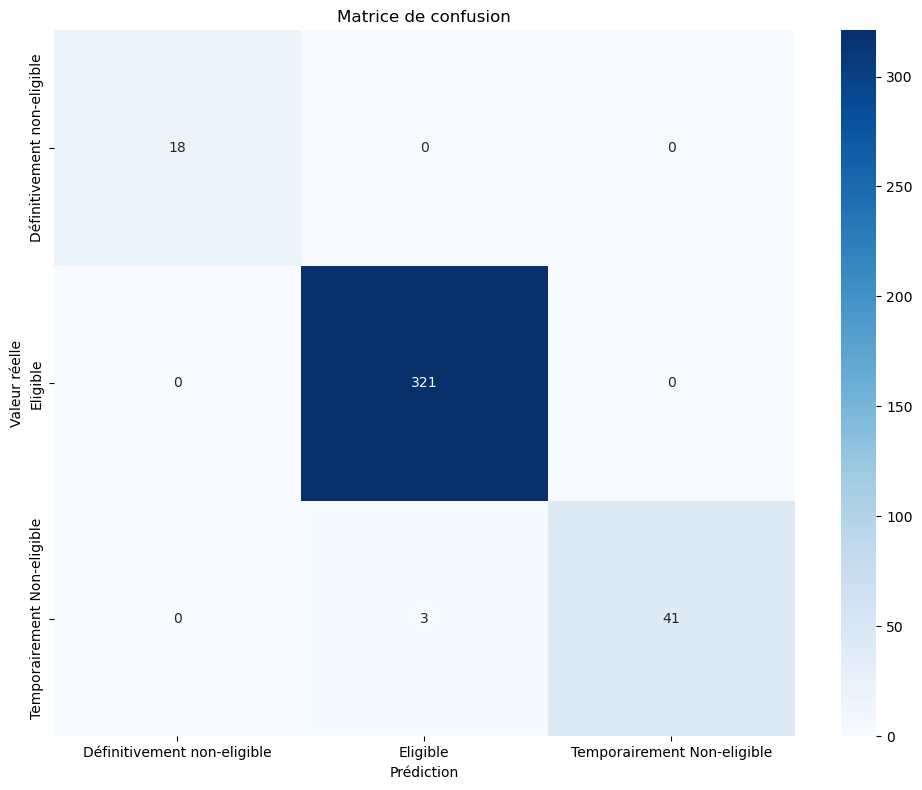

In [40]:
y_pred = pipeline.predict(X_test)

# Pour une classification multiclasse
print("\nRapport de classification:")
print(classification_report(y_test, y_pred))

print("\nMatrice de confusion:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Récupération des classes uniques
classes = np.unique(y)
class_labels = [str(c) for c in classes]  # Convertir en string pour l'affichage

# Affichage de la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Prédiction')
plt.ylabel('Valeur réelle')
plt.title('Matrice de confusion')
plt.tight_layout()
plt.savefig('confusion_matrix.png')


Exactitude par classe:
  Classe 'Définitivement non-eligible': 1.0000
  Classe 'Eligible': 1.0000
  Classe 'Temporairement Non-eligible': 0.9318


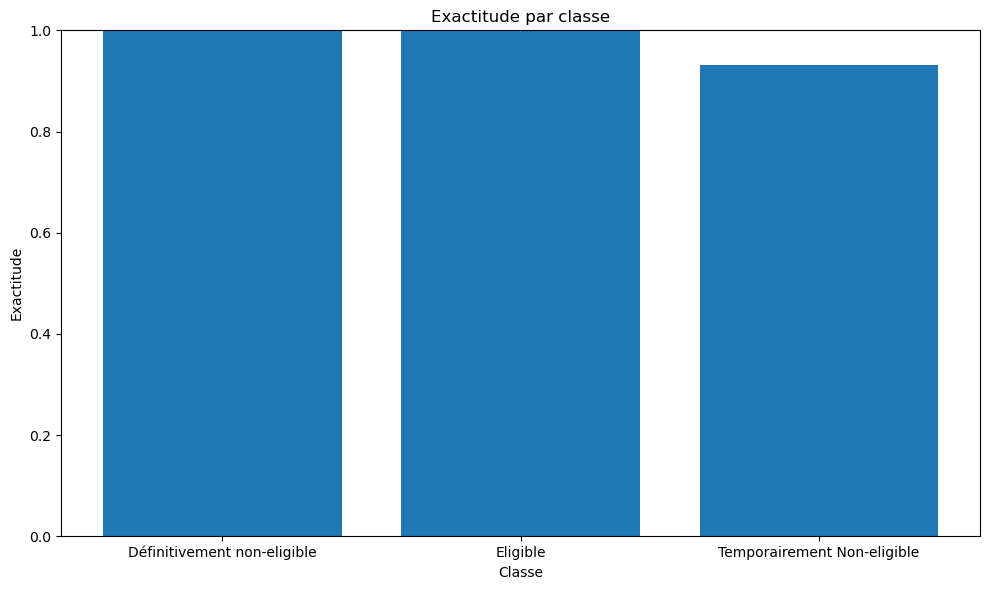

In [41]:
if len(classes) > 2:
    # Exactitude par classe
    class_accuracy = {}
    for i, class_name in enumerate(classes):
        # Vrai positif pour cette classe
        true_pos = conf_matrix[i, i]
        # Total d'exemples de cette classe
        total = np.sum(conf_matrix[i, :])
        class_accuracy[class_name] = true_pos / total if total > 0 else 0
        
    print("\nExactitude par classe:")
    for class_name, acc in class_accuracy.items():
        print(f"  Classe '{class_name}': {acc:.4f}")
    
    # Visualisation de l'exactitude par classe
    plt.figure(figsize=(10, 6))
    plt.bar(class_accuracy.keys(), class_accuracy.values())
    plt.ylim(0, 1)
    plt.xlabel('Classe')
    plt.ylabel('Exactitude')
    plt.title('Exactitude par classe')
    plt.tight_layout()
    plt.savefig('class_accuracy.png')


Importance des variables (top 20):
                          Feature  Importance
577         somme_indispo_commune    0.222395
557        Taux d’hémoglobine bas    0.144255
579              somme_ineligible    0.107194
2              Taux d’hémoglobine    0.074068
567                         Opéré    0.048876
578           somme_indispo_femme    0.039702
556     Est sous anti-biothérapie    0.036585
565     Antécédent de transfusion    0.024974
3                             Age    0.015965
573                        Tatoué    0.012494
572                     Cardiaque    0.010720
10                    Genre_Homme    0.010410
576       Autre_raison_ineligible    0.008948
574                      Scarifié    0.008904
516  Quartier de Résidence_douala    0.008667
9                     Genre_Femme    0.007664
441   Quartier de Résidence_R A S    0.006853
566          Porteur(HIV,hbs,hcv)    0.006605
443     Quartier de Résidence_RAS    0.006156
0                          Taille    0.00588

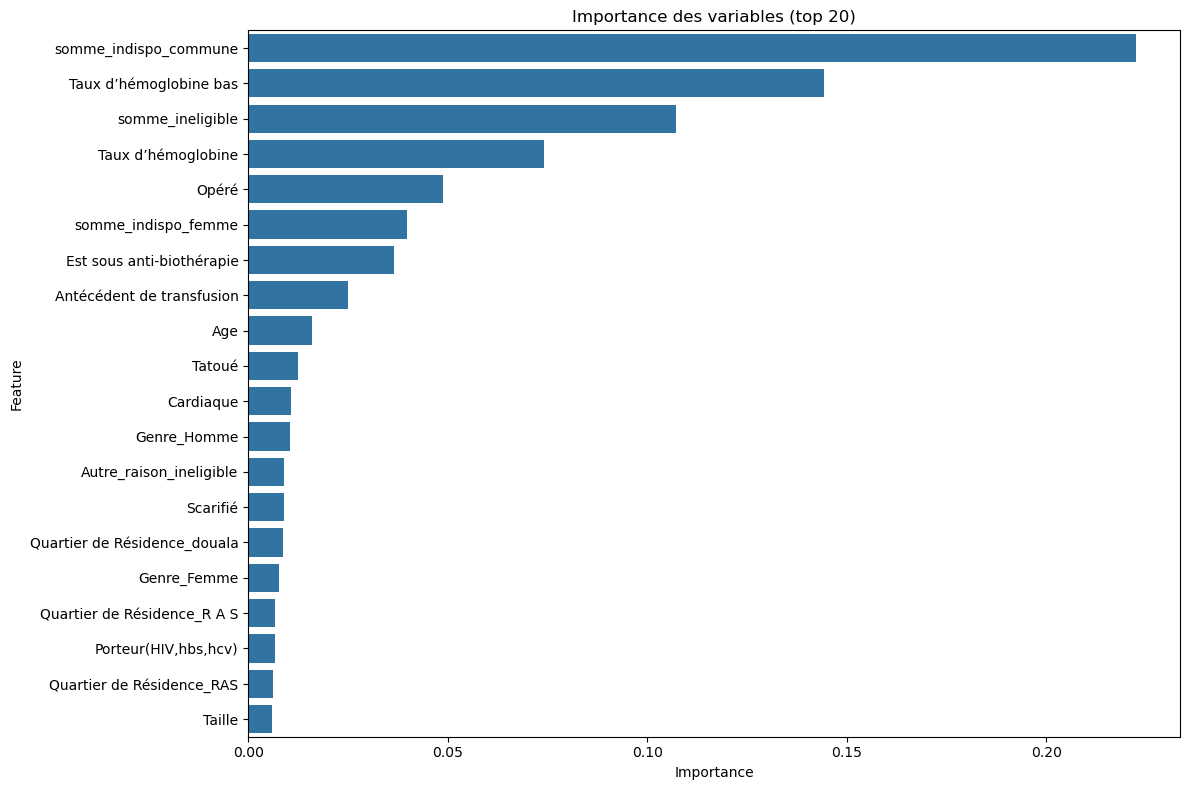

In [42]:
if hasattr(pipeline.named_steps['classifier'], 'feature_importances_'):
    # Récupération des noms des colonnes après transformation
    feature_names = []
    
    # Pour les colonnes numériques
    for col in numeric_cols:
        feature_names.append(col)
    
    # Pour les colonnes catégorielles (avec one-hot encoding)
    if hasattr(pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'], 'get_feature_names_out'):
        cat_feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_cols)
        feature_names.extend(cat_feature_names)
    else:
        # Fallback pour les versions antérieures de scikit-learn
        for col in categorical_cols:
            feature_names.append(col)
    
    # Pour les colonnes booléennes
    for col in bool_columns + ['somme_indispo_commune', 'somme_indispo_femme', 'somme_ineligible']:
        feature_names.append(col)
    
    # Récupération de l'importance des variables
    importances = pipeline.named_steps['classifier'].feature_importances_
    
    # Si la taille des importances ne correspond pas au nombre de noms de features,
    # on utilise des indices à la place des noms
    if len(importances) != len(feature_names):
        feature_names = [f'Feature {i}' for i in range(len(importances))]
    else:
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        })
        feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
        
        print("\nImportance des variables (top 20):")
        print(feature_importance_df.head(20))
        
        # Visualisation de l'importance des variables
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
        plt.title('Importance des variables (top 20)')
        plt.tight_layout()
        plt.savefig('feature_importance.png')

In [43]:
X.columns

Index(['Niveau d'etude', 'Genre', 'Taille', 'Poids',
       'Situation Matrimoniale (SM)', 'Profession_Commune', 'Arr',
       'Quartier de Résidence', 'Religion', 'A-t-il (elle) déjà donné le sang',
       'Taux d’hémoglobine', 'Age', 'Est sous anti-biothérapie',
       'Taux d’hémoglobine bas', 'date de dernier Don < 3 mois',
       'IST récente (Exclu VIH, Hbs, Hcv)',
       'La DDR est mauvais si <14 jour avant le don', 'Allaitement',
       'A accoucher ces 6 derniers mois',
       'Interruption de grossesse  ces 06 derniers mois', 'est enceinte',
       'Antécédent de transfusion', 'Porteur(HIV,hbs,hcv)', 'Opéré',
       'Drepanocytaire', 'Diabétique', 'Hypertendus', 'Asthmatiques',
       'Cardiaque', 'Tatoué', 'Scarifié', 'Autre_raison_indispo_femme',
       'Autre_raison_ineligible', 'somme_indispo_commune',
       'somme_indispo_femme', 'somme_ineligible'],
      dtype='object')

In [44]:
with open('model_eligibilite.pkl', 'wb') as f:
    pickle.dump(pipeline, f)
print("\nModèle sauvegardé avec succès: model_eligibilite.pkl")


Modèle sauvegardé avec succès: model_eligibilite.pkl


In [203]:
sample_profiles = []

# Profil 1: Femme en bonne santé
profil1 = X.iloc[0].copy()  # On prend un exemple existant comme template
# Réinitialisation des valeurs
for col in bool_columns:
    if col in profil1.index:
        profil1[col] = 0
profil1['Genre'] = 'F'  # Femme
profil1['Age'] = 30
profil1['Poids'] = 65
profil1['Taille'] = 165
profil1['Hémoglobine'] = 13.5
sample_profiles.append(('Femme en bonne santé', profil1))

# Profil 2: Homme avec un antécédent de transfusion
profil2 = X.iloc[0].copy()
for col in bool_columns:
    if col in profil2.index:
        profil2[col] = 0
profil2['Genre'] = 'H'  # Homme
profil2['Age'] = 45
profil2['Poids'] = 80
profil2['Taille'] = 175
profil2['Hémoglobine'] = 15.0
profil2['Antécédent de transfusion'] = 1
sample_profiles.append(('Homme avec antécédent de transfusion', profil2))

# Profil 3: Femme enceinte
profil3 = X.iloc[0].copy()
for col in bool_columns:
    if col in profil3.index:
        profil3[col] = 0
profil3['Genre'] = 'F'  # Femme
profil3['Age'] = 28
profil3['Poids'] = 68
profil3['Taille'] = 162
profil3['Hémoglobine'] = 12.0
profil3['est enceinte'] = 1
sample_profiles.append(('Femme enceinte', profil3))

# Profil 4: Homme avec taux d'hémoglobine bas
profil4 = X.iloc[0].copy()
for col in bool_columns:
    if col in profil4.index:
        profil4[col] = 0
profil4['Genre'] = 'H'  # Homme
profil4['Age'] = 35
profil4['Poids'] = 70
profil4['Taille'] = 180
profil4['Hémoglobine'] = 11.0
profil4['Taux d\'hémoglobine bas'] = 1
sample_profiles.append(('Homme avec taux d\'hémoglobine bas', profil4))

# Profil 5: Femme ayant accouché récemment et avec hémoglobine basse
profil5 = X.iloc[0].copy()
for col in bool_columns:
    if col in profil5.index:
        profil5[col] = 0
profil5['Genre'] = 'F'  # Femme
profil5['Age'] = 32
profil5['Poids'] = 60
profil5['Taille'] = 160
profil5['Hémoglobine'] = 10.5
profil5['A accoucher ces 6 derniers mois'] = 1
profil5['Taux d’hémoglobine bas'] = 1
sample_profiles.append(('Femme ayant accouché récemment avec hémoglobine basse', profil5))


In [204]:
print("\nRésultats des prédictions:")
for nom, profil in sample_profiles:
    # Prétraitement spécifique au genre
    profil_processed = gender_specific_preprocessing(pd.DataFrame([profil]), female_specific_cols).iloc[0]
    
    # Prédiction
    prediction = pipeline.predict([profil_processed])[0]
    
    # Pour une classification multiclasse, on récupère les probabilités pour chaque classe
    probabilities = pipeline.predict_proba([profil_processed])[0]
    
    print(f"Profil: {nom}")
    print(f"  - Prédiction: {prediction}")
    
    # Affichage des probabilités pour chaque classe
    print("  - Probabilités par classe:")
    for i, class_name in enumerate(pipeline.classes_):
        print(f"    • {class_name}: {probabilities[i]:.2%}")
    print("")




Résultats des prédictions:


ValueError: X has 37 features, but ColumnTransformer is expecting 36 features as input.

In [ ]:
import smtplib
import socket
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

def send_upload_notification_email(filename, language):
    # Email configuration
    sender_email = "kosprogcrepin@gmail.com"
    sender_password = "logy mvpc lent enok"
    recipient_email = "crepinkoulo@gmail.com"

    # Email content based on language
    if language == 'fr':
        subject = "Mise à jour réussie de la base de données"
        body = f"Le fichier {filename} a été uploadé avec succès dans le système de dashboard de don de sang."
    else:
        subject = "Successful Database Update"
        body = f"The file {filename} has been successfully uploaded to the blood donation dashboard system."

    try:
        # Set a longer timeout
        socket.setdefaulttimeout(30)  # 30 seconds timeout

        # Create message
        message = MIMEMultipart()
        message['From'] = sender_email
        message['To'] = recipient_email
        message['Subject'] = subject

        # Attach body
        message.attach(MIMEText(body, 'plain'))

        # Create SMTP session with more robust connection
        with smtplib.SMTP('smtp.gmail.com', 587) as server:
            server.ehlo()  # Can help with connection issues
            server.starttls()  # Use TLS encryption
            server.ehlo()  # Call ehlo again after starttls
            server.login(sender_email, sender_password)
            server.sendmail(sender_email, recipient_email, message.as_string())
            print("Email notification sent successfully")

    except socket.timeout:
        print("Connection timed out. Check your internet connection.")
    except smtplib.SMTPException as e:
        print(f"SMTP error occurred: {e}")
    except Exception as e:
        print(f"Failed to send email notification: {e}")

In [18]:
send_upload_notification_email(filename='hfdfv', language='fr')

Email notification sent successfully
